## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
from pathlib import Path

## Load dataset

In [2]:
path = Path().cwd()
data_file = path.parent / "Data" / "ACS.csv"

dataFrame = pd.read_csv(data_file)

dataTrain = np.asarray(dataFrame)[dataFrame['Train'] == 1,:]
dataTest = np.asarray(dataFrame)[dataFrame['Train'] == 0,:]

# split data -> some data is completely outside CV-optimization to reduce overfitting

# normal way of doing it;
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
# But we already have indexes in the dataFrame;
X_train = dataTrain[:,:-2]
y_train = dataTrain[:,-2:-1].ravel() # Second to last row in dataframe is class

X_test = dataTest[:,:-2]
y_test = dataTest[:,-2:-1].ravel() # Second to last row in dataframe is class

### 5. Compute a suitable Support Vector Machine (SVM) classifier for the acute coronary syndrome data in ACS.csv. Use the matrix Xtruncated as the data matrix and y as the response variable. Find suitable parameters for a kernel SVM using 10-fold cross-validation and misclassification rate (MCR) as criterion.

In [3]:
# First Logistic regression <- below is extremely naiv way to use it, rampant overfit is expected
# warning is due to perfect separation of data
LogModel = LogisticRegression()
yhat_log = LogModel.fit(X_train, y_train).predict(X_test)
LogModelAcc = abs(sum(yhat_log == y_test))/len(y_test) # a bit better then the simple imple. in matlab

kernelType = ["rbf", "poly", "sigmoid"]
                
cVal = np.logspace(-3,3)
                
clf = svm.SVC(degree=3, shrinking = False,)
# Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
param_grid = {
    'kernel': kernelType,
    'C': cVal
}

rf_grid = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 10, verbose=2, n_jobs=5)

# Fit the grid search model
rf_grid.fit(X_train, y_train)

print(rf_grid.best_estimator_)

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


/home/kvol/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(C=0.001, shrinking=False)


Logistic Regression accuracy of 0.90, and svm accuracy of 0.92


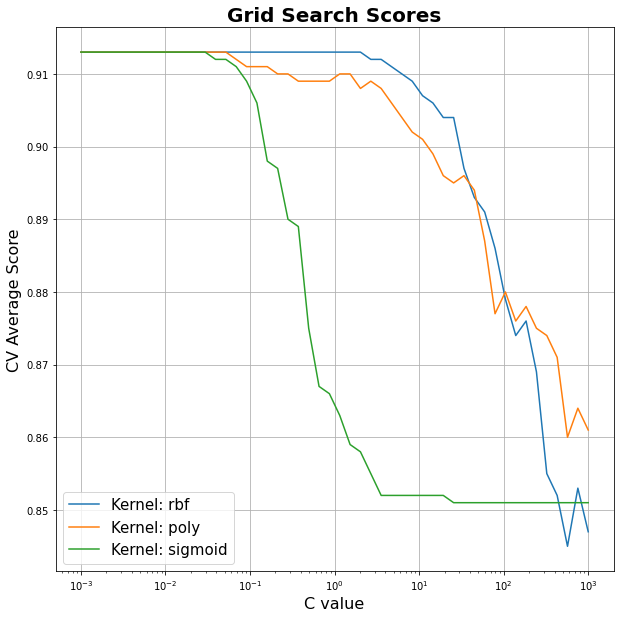

In [4]:
# Get Test Scores Mean and std for each grid search
scores_mean = rf_grid.cv_results_['mean_test_score']
scores_mean = np.array(scores_mean).reshape(len(cVal),len(kernelType))

# Plot Grid search scores
_, ax = plt.subplots(1,1, figsize=(10,10))

# Param1 is the X-axis, Param 2 is represented as a different curve (color line)
for idx, val in enumerate(kernelType):
    ax.plot(cVal, scores_mean[:, idx], '-', label= 'Kernel: ' + str(val))

ax.set_xscale('log')
ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel("C value", fontsize=16)
ax.set_ylabel('CV Average Score', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')

modelOpt = rf_grid.best_estimator_
modelOpt = modelOpt.fit(X_train, y_train)
y_est_test = modelOpt.predict(X_test)
acc_svm = np.abs(sum(y_est_test == y_test))/len(y_test)
print("Logistic Regression accuracy of %0.2f, and svm accuracy of %0.2f" % (LogModelAcc, acc_svm))